# Lab for answering question C
Responsible: Moritz
Question: Are there trends visible that could be due to climate change?

In [60]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functools import lru_cache
from scipy import stats
from sklearn.linear_model import LinearRegression
%run -i utility_functions.py

Loading the files from the transformation notebook

In [169]:
transformed_df_serial_path = "../data/data_transformed.pickle"

with open(transformed_df_serial_path, "rb") as file:
    df: pd.DataFrame = pickle.load(file)

assert isinstance(df, pd.DataFrame),f"The serialized object in {transformed_df_serial_path} is not a pandas dataframe!"
assert len(df)!=0, "The serialized dataframe contains no data!"


with open("../data/country_temp_delta.pickle", "rb") as file:
    country_temp_delta: pd.DataFrame = pickle.load(file)


,Disaster_Group,Disaster_Subgroup,Disaster_Type,Disaster_Subtype,Disaster_Subsubtype,Country,ISO,Region,Continent,Associated_Dis,Associated_Dis2,Start_Year,End_Year,Total_Deaths,Total_Affected,Disaster_Decade
0,Natural,Climatological,Drought,Drought,<NA>,Cabo Verde,CPV,Western Africa,Africa,Famine,<NA>,1900,1900,11000,<NA>,1900
1,Natural,Climatological,Drought,Drought,<NA>,India,IND,Southern Asia,Asia,<NA>,<NA>,1900,1900,1250000,<NA>,1900
2,Natural,Geophysical,Earthquake,Ground movement,<NA>,Guatemala,GTM,Central America,Americas,Tsunami/Tidal wave,<NA>,1902,1902,2000,<NA>,1900
3,Natural,Geophysical,Volcanic activity,Ash fall,<NA>,Guatemala,GTM,Central America,Americas,<NA>,<NA>,1902,1902,1000,<NA>,1900
4,Natural,Geophysical,Volcanic activity,Ash fall,<NA>,Guatemala,GTM,Central America,Americas,<NA>,<NA>,1902,1902,6000,<NA>,1900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16483,Natural,Biological,Epidemic,Viral disease,<NA>,Congo (the Democratic Republic of the),COD,Middle Africa,Africa,<NA>,<NA>,2022,2022,8,607,2020
16484,Natural,Biological,Epidemic,Viral disease,<NA>,Congo (the Democratic Republic of the),COD,Middle Africa,Africa,<NA>,<NA>,2022,2022,5,141,2020
16485,Natural,Biological,Epidemic,Viral disease,<NA>,Zimbabwe,ZWE,Eastern Africa,Africa,<NA>,<NA>,2022,2022,750,6551,2020
16486,Natural,Biological,Epidemic,Viral disease,<NA>,Timor-Leste,TLS,South-Eastern Asia,Asia,<NA>,<NA>,2022,2022,20,1353,2020


Loading the disaster classification

In [62]:
disaster_classification: pd.DataFrame = pd.read_csv("../data/disaster_classification.csv")
disaster_subgroups = set(disaster_classification.loc[disaster_classification["Disaster Sub-Group"].notna(), "Disaster Sub-Group"])

Loading the NASA yearly global temperature data, source: [https://climate.nasa.gov/vital-signs/global-temperature/](https://climate.nasa.gov/vital-signs/global-temperature/)

In [63]:
yearly_global_temp: pd.DataFrame = pd.read_csv("../data/nasa_yearly_global_temperature.csv", index_col="Year").rename(columns={"Temp_No_Smoothing": "Temperature Delta"})
yearly_global_temp

,Temperature Delta,Temp_Lowess(5)
Year,,
1880,-0.18,-0.10
1881,-0.09,-0.14
1882,-0.11,-0.17
1883,-0.17,-0.20
1884,-0.28,-0.24
...,...,...
2017,0.92,0.91
2018,0.85,0.92
2019,0.98,0.93


Dumping all data before 1950 as it is not relevant to climate change.

In [190]:
cutoff_year = 1950 # TODO check
df = df[df["Start_Year"] >= cutoff_year]
min_year = df["Start_Year"].min()
max_year = df["Start_Year"].max()

yearly_global_temp = yearly_global_temp[yearly_global_temp.index >= cutoff_year]

## Get Yearly Deaths

Read the documentation in utility_functions.py for info on parameters etc.

In [65]:
get_yearly_deaths(df, include_zero=True).to_frame() # Deaths grouped by year. Rows with zero deaths can be excluded

,Total_Deaths
Year,
1950,6845.0
1951,18227.0
1952,6886.0
1953,12997.0
1954,41847.0
...,...
2018,13832.5
2019,23838.166667
2020,15690.166667


In [66]:
get_yearly_deaths(df, custom_index=["Country", "Disaster_Subtype"], include_zero=False).to_frame() # Deaths can be grouped by year and each of custom_index

Total_Deaths
Year Country                            Disaster_Subtype              
1950 Antigua and Barbuda                Tropical cyclone           2.0
     Colombia                           Ground movement          211.0
     India                              Ground movement         1500.0
                                        Riverine flood            45.0
     Indonesia                          Ground movement           16.0
...                                                                ...
2022 Venezuela (Bolivarian Republic of) Landslide                109.0
     Viet Nam                           Convective storm          11.0
                                        Tropical cyclone          19.0
     Yemen                              Flash flood               13.0
     Zimbabwe                           Viral disease            750.0

[6578 rows x 1 columns]

## Regarding Groupby and Pandas Datatypes

Pandas usually uses numpy datatypes. However, **numpy integer arrays do not allow for null values (np.nan)**. That's why pandas introduces their own Integer array, which can inlcude null values (pd.NA). However, for groupby operations these pd.NA values can cause problems, so it is advisable to convert back to a numpy float array (which does allow for np.nan) before applying the groupby.

In [67]:
series = pd.Series(np.arange(10)) # just for demonstration

series.astype("int32") # <-- "int32" (small i) = numpy int, no empty values
series.astype("Int32") # <-- "Int32" (big i) = pandas int, allows empty values (pd.NA)
series.astype("float32") # <-- numpy float, allows empty values (np.nan)
pass

In [192]:
groupby_base = df.astype({"Total_Deaths": np.float64, "Total_Affected": np.float64, "Start_Year": np.int32, "Disaster_Decade": np.int32})
groupby_base = groupby_base[groupby_base["Disaster_Decade"] < 2020]
groupby_base[["Disaster_Subgroup", "Total_Deaths"]].groupby(["Disaster_Subgroup"]).mean()

,Total_Deaths
Disaster_Subgroup,
Biological,215.214689
Climatological,9342.864979
Extra-terrestrial,NaN
Geophysical,1409.102463
Hydrological,554.114710
Meteorological,332.690490


## Data Exploration

In [231]:
year_range = range(min_year, max_year)

def fill_missing_year():
    set(groupby_base.groupby("Start_Year").size().rename("No_Disasters").index).difference(year_range)
    # TODO

def get_yearly_disaster_count(groupby_base: pd.DataFrame, index_cols:list=None, include_zero:bool=True) -> pd.Series:
    """Calculates number of disaster occurrences grouped by the secondary_index column for each Start_Year.

    Parameters
    ----------
    secondary_index: str
        Must be a column label of groupby_base.
        Probably one of [Disaster_Subgroup, Disaster_Type, Disaster_Subtype, Disaster_Subsubtype]
        If None than result will not be grouped.
    include_zero: bool
        If True zero counts will be included, otherwise the rows are dropped
    Returns
    -------
    pd.Series named "No_Disasters"
    """


    index = index_cols if index_cols is not None else ["Start_Year"]
    if not include_zero:
        return groupby_base.groupby(index).size().rename("No_Disasters")

    count_nonzero = get_yearly_disaster_count(groupby_base=groupby_base, index_cols=index_cols, include_zero=False)
    if index_cols is not None:
        return count_nonzero.unstack(fill_value=0).stack().rename("No_Disasters")
    return count_nonzero

def get_yearly_pct_change_to_initial(groupby_base: pd.DataFrame, index_cols:list=None):
    """Calculates yearly percentage change number of disaster occurrences compared to the first year, grouped by the respective column.

    Parameters
    ----------
    secondary_index: str
        Must be a column label of groupby_base.
        Probably one of [Disaster_Subgroup, Disaster_Type, Disaster_Subtype, Disaster_Subsubtype]

    Returns
    -------
    pd.Series with Multiindex ("Start_Year", secondary_index) and named "Percent_Change"
    """
    count_nonzero = get_yearly_disaster_count(groupby_base=groupby_base, index_cols=index_cols, include_zero=False)
    if index_cols is not None:
        return count_nonzero.groupby(level=[1], group_keys=False).apply(lambda x: (x.div(x.iloc[0]) -1) *100).fillna(0).rename("Percent_Change")
    percent_change = (count_nonzero.div(count_nonzero.iloc[0]) -1) *100
    return percent_change.fillna(0).rename("Percent_Change")


Text(0.5, 0, 'Year AC.')

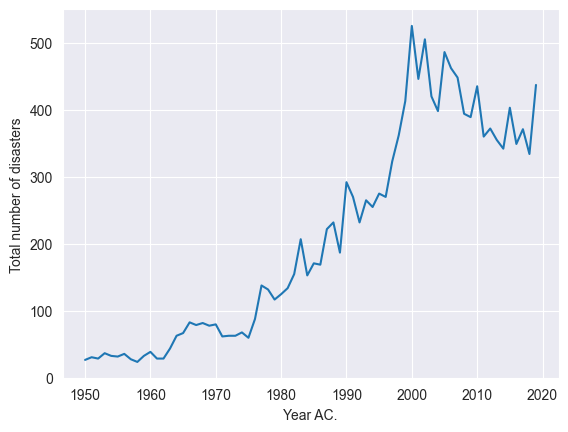

In [232]:
total_disaster_per_year = get_yearly_disaster_count(groupby_base, include_zero=True)
plt.plot(total_disaster_per_year.index, total_disaster_per_year)
plt.ylabel("Total number of disasters")
plt.xlabel("Year AC.")

<AxesSubplot: xlabel='Disaster_Decade', ylabel='No_Disasters'>

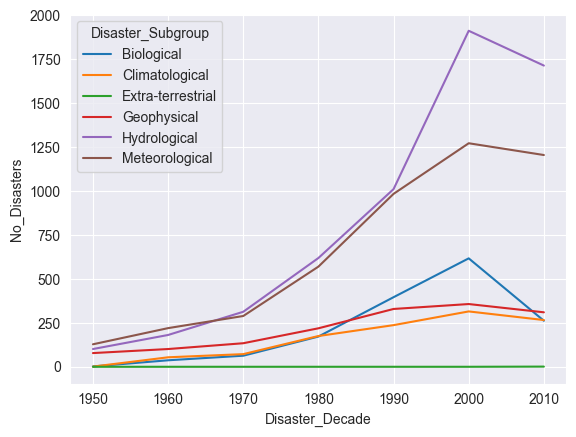

In [196]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Disaster_Decade","Disaster_Subgroup"]).reset_index(), x="Disaster_Decade",y="No_Disasters", hue="Disaster_Subgroup")

<AxesSubplot: xlabel='Start_Year', ylabel='Percent_Change'>

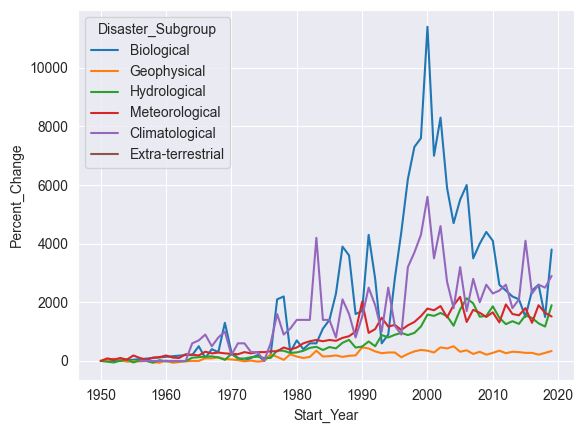

In [198]:
# disaster_subgroup = disaster_classification["Disaster Sub-Group"]
sns.lineplot(data=get_yearly_pct_change_to_initial(groupby_base, index_cols=["Start_Year","Disaster_Subgroup"]).reset_index(),
             x="Start_Year",
             y="Percent_Change",
             hue="Disaster_Subgroup")

<AxesSubplot: xlabel='Start_Year', ylabel='No_Disasters'>

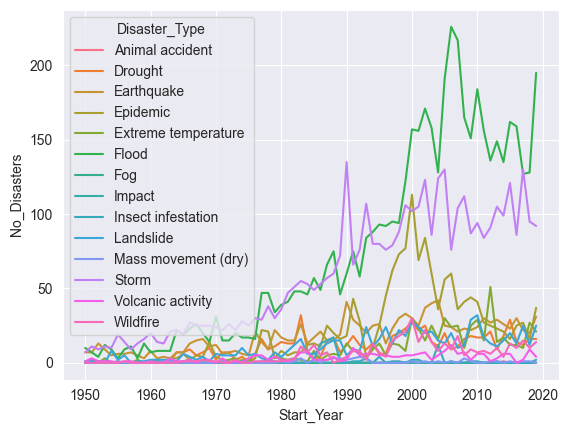

In [200]:
sns.lineplot(data=get_yearly_disaster_count(groupby_base, index_cols=["Start_Year","Disaster_Type"]).reset_index(),
             x="Start_Year",
             y="No_Disasters",
             hue="Disaster_Type")

## Trends in the number of Disasters
### Number of total Disasters


In [236]:
yearly_temp_disasters = pd.concat((yearly_global_temp, get_yearly_disaster_count(groupby_base)), axis="columns")#.rename_axis("Year")
yearly_temp_disasters["Disaster_Decade"] = yearly_temp_disasters.index//10*10
yearly_temp_disasters

,Temperature Delta,Temp_Lowess(5),No_Disasters,Disaster_Decade
1950,-0.17,-0.07,27.0,1950
1951,-0.07,-0.07,31.0,1950
1952,0.01,-0.07,29.0,1950
1953,0.08,-0.07,37.0,1950
1954,-0.13,-0.06,33.0,1950
...,...,...,...,...
2017,0.92,0.91,371.0,2010
2018,0.85,0.92,334.0,2010
2019,0.98,0.93,437.0,2010
2020,1.02,0.93,NaN,2020


Correlation coefficient: 0.8884246811517343


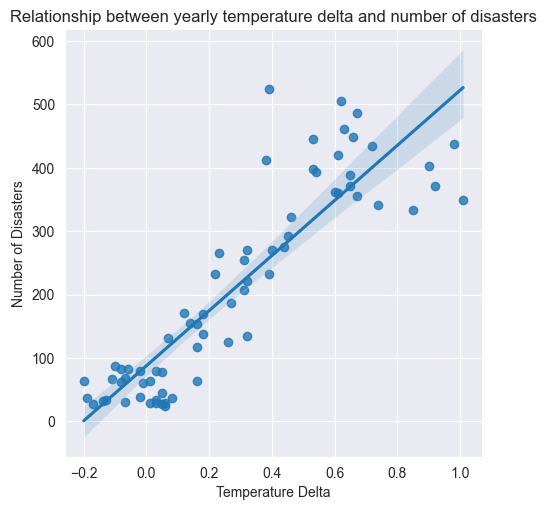

In [241]:
sns.lmplot(data=yearly_temp_disasters, x="Temperature Delta", y="No_Disasters")
plt.xlabel("Temperature Delta")
plt.ylabel("Number of Disasters")
plt.title("Relationship between yearly temperature delta and number of disasters")
print(f"Correlation coefficient: {yearly_temp_disasters['Temperature Delta'].corr(yearly_temp_disasters['No_Disasters'])}")

In the graph above, a linear regression is depicted to show the supposed impact of rising temperatures on the number of natural disaster occurrences. Specially, the linear regression is performed on the global temperature delta of a given year to long-term average (x-axis) and the Number of natural disasters in that year (y-axis).

Text(0.5, 1.0, 'Relationship between decade-wise temperature delta and change-rate of disaster occurrences')

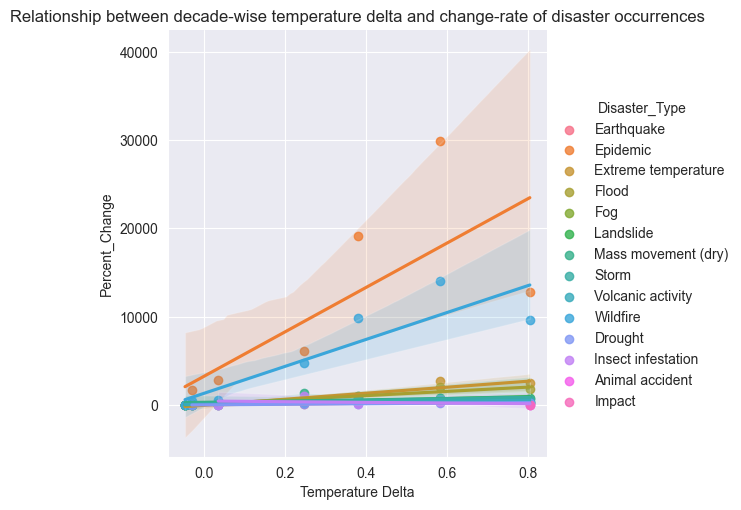

In [246]:
yearly_disaster_temp_by_subgroup = get_yearly_pct_change_to_initial(groupby_base, index_cols=["Disaster_Decade","Disaster_Type"]).to_frame()

yearly_disaster_temp_by_subgroup["Temperature Delta"] = 0

yearly_disaster_temp_by_subgroup["Temperature Delta"] = yearly_disaster_temp_by_subgroup["Temperature Delta"].add(yearly_temp_disasters.groupby("Disaster_Decade")["Temperature Delta"].mean().drop(2020))

yearly_disaster_temp_by_subgroup.reset_index(inplace=True)
sns.lmplot(data=yearly_disaster_temp_by_subgroup, x="Temperature Delta", y="Percent_Change", hue="Disaster_Type")
plt.title("Relationship between decade-wise temperature delta and change-rate of disaster occurrences")

In [244]:
yearly_country_disasters = get_yearly_disaster_count(groupby_base, index_cols=["Start_Year", "Country"], include_zero=True).reset_index()
countrywise_year_disastercount_correlation = yearly_country_disasters.groupby('Country')[["Start_Year", "No_Disasters"]].corr().iloc[0::2,-1].reset_index(level=1, drop=True).rename("Year-DisasterCount Correlation")

In [245]:
countries_complete = pd.concat((country_temp_delta, countrywise_year_disastercount_correlation), axis="columns", join="inner")
countries_complete

,Region,Warming/Century,Uncertainty (±),Year-DisasterCount Correlation
Country,,,,
Afghanistan,Asia,3.32,0.34,0.698776
Albania,Europe,1.97,0.28,0.531263
Algeria,Africa,2.86,0.28,0.420825
American Samoa,NaN,1.43,0.57,0.174269
Angola,Africa,1.61,0.34,0.662275
...,...,...,...,...
Uruguay,South America,1.56,0.45,0.551514
Uzbekistan,Asia,2.72,0.29,0.216621
Yemen,Asia,2.50,0.55,0.631661


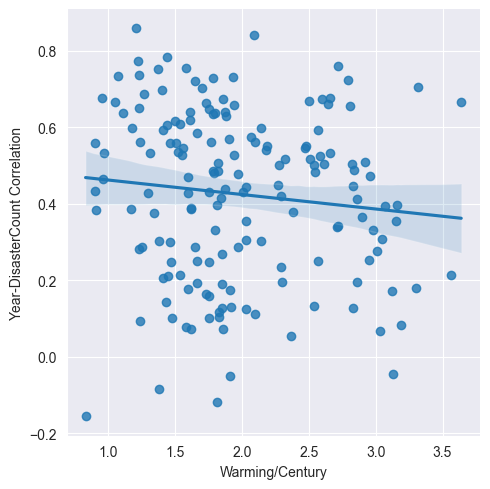

In [78]:
#countries_complete["Warming/Century"].corr(countries_complete["Year-DisasterCount Correlation"])
sns.lmplot(data=countries_complete, x="Warming/Century", y="Year-DisasterCount Correlation")

Backup

In [79]:
first_year_index = tuple(no_disasters_per_type_and_year[min_year].index)

missing_from_first = disaster_subgroups.difference(first_year_index)
no_disasters_per_type_and_year.add(
    pd.Series(
        data=np.zeros(len(missing_from_first)),
        index=pd.MultiIndex.from_tuples([(min_year, subgroup) for subgroup in missing_from_first])))


NameError: name 'no_disasters_per_type_and_year' is not defined